# Case study - Time Series Forecast

Table Of Contents:

* Introduction
* Abstract
* Libraries
* Get Data
* Data Pre Processing
* Exploratory data analysis
* Feature Importance
* Feature selection
* Choose Model & Hyperparameters Tuning
* Make Prediction
* Evaluate Prediction
* Summary

**Introduction**

We Try to Forecast 3 Month Bicycle Rentals on Hourly Interval based on endogen, exogens features

**Abstract**


Data Contain 40% sparse data(zeros). <br>
Our model show bias prediction which not allow us to deploy model. <br>
My recommendation is to change time frame from hourly to 6 hours.

**Libraries**

In [4]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

**Get Data**

In [5]:
from google.colab import drive
drive.mount('/colab/')
from google.colab import files
uploaded = files.upload()

Drive already mounted at /colab/; to attempt to forcibly remount, call drive.mount("/colab/", force_remount=True).


Saving data.csv to data (1).csv


In [6]:
import io

df = pd.read_csv(io.BytesIO(uploaded['data.csv']),index_col='datetime',parse_dates=True)

In [7]:
display(df.shape)
df.head()

(10886, 11)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


 *   When we resampling data in hourly frequency we will get observations contain zeros (sparse data). <br> those zeros will be treated in data cleaning section. <br>
**'Holiday', 'Workingday' are binary attributes.** <br>
Therefore, **we need to replace zeros with -1** and will replace vice versa during data cleaning section.


In [8]:
df['holiday'] = df['holiday'].apply(lambda x: -1 if x==0 else x)
df['workingday'] = df['workingday'].apply(lambda x: -1 if x==0 else x)

In [9]:
# Aggregate data hourly
df = df.resample('h').sum() 
df.shape

(17256, 11)

 * Observations increased from 10,886 to 17,256 meaning we have a lot of hours  without Rentals (Sparse data).
 * **Sparse data can cause to biased results and recommend to change time frame to higher resulation like every 2 hours, day frequencies**
 * For this moment we should create algoritm which predict data hourly according to business definitions.
 * we should treat missing data 

**Data Pre Processing**

* Data Cleaning
* Impute Missing values on attributes (Zeros)
* Transform Data Types


* Data Cleaning

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17256 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Freq: H
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17256 non-null  int64  
 1   holiday     17256 non-null  int64  
 2   workingday  17256 non-null  int64  
 3   weather     17256 non-null  int64  
 4   temp        17256 non-null  float64
 5   atemp       17256 non-null  float64
 6   humidity    17256 non-null  int64  
 7   windspeed   17256 non-null  float64
 8   casual      17256 non-null  int64  
 9   registered  17256 non-null  int64  
 10  count       17256 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1.6 MB


There isn't missing values

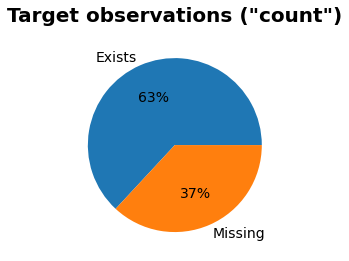

In [11]:
threshold = df['count'].apply(lambda x: 1 if x == 0 else 0).to_frame('missing')
ax=threshold.value_counts().plot(kind='pie',autopct="%.f%%",labels= ['Exists','Missing'] ,textprops={'fontsize': 14})
ax.set_ylabel('');
ax.set_title('Target observations ("count")',size=20,pad=15,fontweight='bold');

**'Count' - target contain 37% missing values.<br>
This issue will burden on our prediction and cause to bias results.**

* Impute Missing values on attributes (Zeros)

In [12]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,17256.000000,17256.000000,17256.000000,17256.000000,17256.000000,17256.000000,17256.000000,17256.000000,17256.00000,17256.000000,17256.000000
mean,1.581305,-0.594808,0.228210,0.894819,12.762699,14.922882,39.041261,8.074537,22.72456,98.130563,120.855123
std,1.499733,0.526377,0.760793,0.849705,11.559260,13.252275,33.549948,8.955684,43.32184,141.513856,171.017327
min,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,1.000000,-1.000000,0.000000,1.000000,13.120000,15.150000,44.000000,7.001500,3.00000,25.000000,29.000000
75%,3.000000,0.000000,1.000000,1.000000,22.960000,26.515000,68.000000,15.001300,27.00000,156.000000,194.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,45.455000,100.000000,56.996900,367.00000,886.000000,977.000000


Numerical data contain zeros will interpolate by nearest value

In [13]:
# Numerical data
sparse_numericals = ['temp','atemp','humidity','windspeed']
for column in sparse_numericals:
   df[column].replace(0, np.nan, inplace=True)
   df[column].interpolate(method='nearest',inplace=True)

categorical data contain zeros will by forward fill

In [14]:
# Categorical Data
sparse_categoricals = ['season','holiday','workingday','weather']
for column in sparse_categoricals:
   df[column].replace(0, np.nan, inplace=True)
   df[column].fillna(method='ffill',inplace=True)

'Windspeed' contain NaN treat by backward fill

In [15]:
# replace NaN with backward fill
df['windspeed'].fillna(method='bfill',inplace=True)

In [16]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,17256.000000,17256.000000,17256.000000,17256.000000,17256.000000,17256.000000,17256.000000,17256.000000,17256.00000,17256.000000,17256.000000
mean,2.482615,-0.962448,0.381085,1.429937,18.234070,21.529892,63.465577,13.770278,22.72456,98.130563,120.855123
std,1.109815,0.271475,0.924567,0.643686,8.050872,8.831177,18.683246,7.114871,43.32184,141.513856,171.017327
min,1.000000,-1.000000,-1.000000,1.000000,0.820000,0.760000,8.000000,6.003200,0.00000,0.000000,0.000000
25%,1.000000,-1.000000,-1.000000,1.000000,11.480000,13.635000,49.000000,7.001500,0.00000,0.000000,0.000000
50%,2.000000,-1.000000,1.000000,1.000000,18.040000,21.970000,63.000000,12.998000,3.00000,25.000000,29.000000
75%,3.000000,-1.000000,1.000000,2.000000,24.600000,29.545000,79.000000,19.001200,27.00000,156.000000,194.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,45.455000,100.000000,56.996900,367.00000,886.000000,977.000000


Treat 'holiday' & workingday convert -1 to 0 (for more info: go to get data section)

In [17]:
df['holiday'] = df['holiday'].apply(lambda x: 0 if x==-1 else x)
df['workingday'] = df['workingday'].apply(lambda x: 0 if x==-1 else x)

In [18]:
df[['holiday','workingday']].describe()

,holiday,workingday
count,17256.000000,17256.000000
mean,0.018776,0.690542
std,0.135737,0.462283
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,0.000000,1.000000
max,1.000000,1.000000


* Transform Data Types

In [19]:
to_obj = ['season','holiday','workingday','weather']

def to_object(x):
    return x.astype(str)

for column in to_obj :
    df[column] = to_object(df[column])

'season','holiday','workingday','weather' transformed to categorical data

**Exploratory Data Analysis**

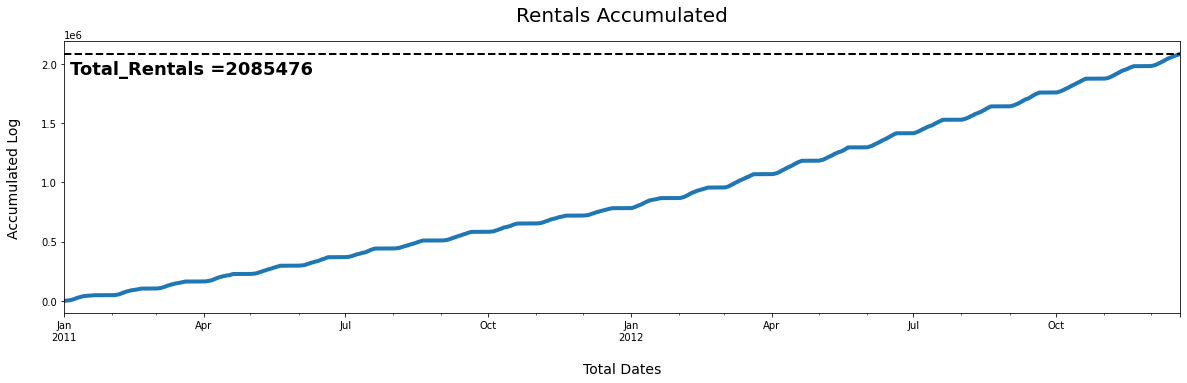

In [20]:
ax=df['count'].cumsum().plot(linewidth=4,figsize=(20, 5));
ax.set_title("Rentals Accumulated",size=20,pad=20);
ax.set_ylabel('Accumulated Log',labelpad=20, size=14);
ax.set_xlabel('Total Dates',labelpad=20, size=14);
total_rentals = df['count'].cumsum().tail(1)[0];
ax.axhline(y=total_rentals, linewidth=2, color='black',linestyle='--');
ax.text(0.005,0.88, f'Total_Rentals ={total_rentals}',size=18,weight="bold", transform=ax.transAxes);


Rentals Increase Exponential - great !

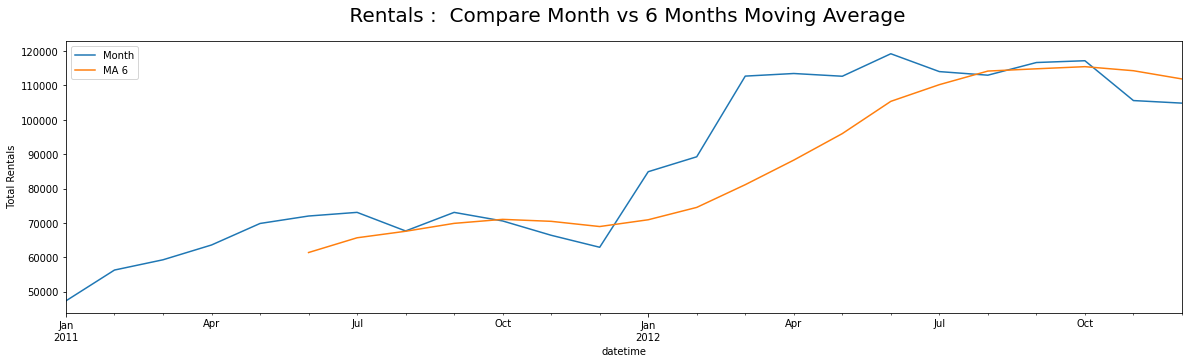

In [21]:
ax=df['count'].resample('M').sum().plot(label='Month', legend=True,figsize=(20,5));
ax= df['count'].resample('M').sum().rolling(window=6).mean().plot(label='MA 6', legend=True,figsize=(20,5));
ax.set_title(' Rentals :  Compare Month vs 6 Months Moving Average',size=20,pad=20);
ax.set_ylabel(' Total Rentals');

  Moving average 6 Month trend line show uptrend. <br>
  In last 2 months we can see rentals below the trend line. <br>
  Same as in the same period previous year. <br>
  We can assume November,  December are weak rental months
  Need more investigation.

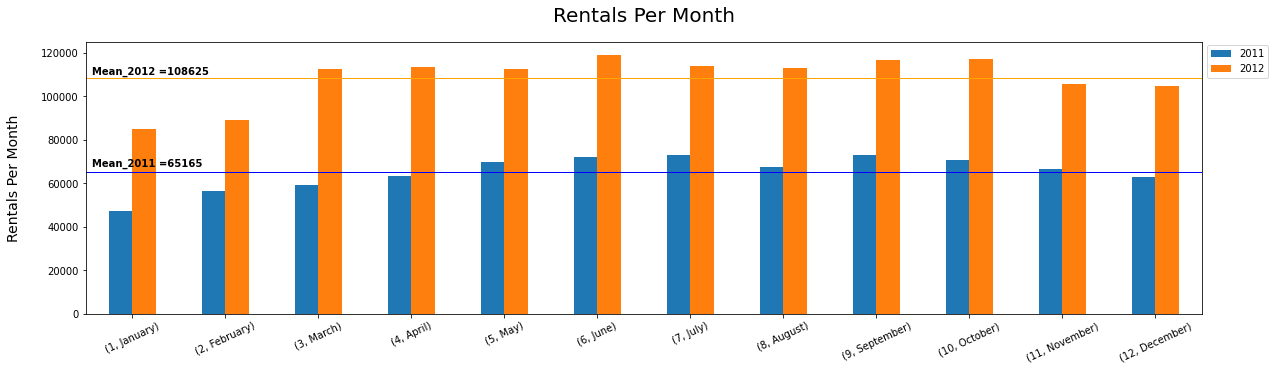

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
df['month'] = df.index.month
df['month_name']= df.index.month_name()
df['year']= df.index.year

ax=df.sort_values(by='month',ascending=True).groupby(['month','month_name','year'])['count'].sum().unstack().plot.bar(figsize=(20,5),rot=25);
ax.legend(loc=3, bbox_to_anchor=(1.,0.85));
mean_2011 =df.loc[df['year']==2011,:].groupby(['month','month_name','year'])['count'].sum().mean();
ax.axhline(y=mean_2011,linewidth=1, color='b');
mean_2012 = df.loc[df['year']==2012,:].groupby(['month','month_name','year'])['count'].sum().mean();
ax.axhline(y=mean_2012,linewidth=1, color='orange');
ax.text(0.005,0.54, f'Mean_2011 ={round(mean_2011)}',weight="bold", transform=ax.transAxes)
ax.text(0.005,0.88, f'Mean_2012 ={round(mean_2012)}',weight="bold" ,transform=ax.transAxes)
ax.set_ylabel('Rentals Per Month',labelpad=20, size=14)
ax.set_xlabel('')
ax.set_title('Rentals Per Month',size=20,pad=20)
plt.show()

* Rentals per month in 2012 increase 66% in average compare 2011 
* Top 3 Months by order (1-good) :
  1. June
  2. September
  3. October
* Bottom 3 Months By order (12-worst) :
  10. December
  11. February
  12. January

* Rentals by chart seems like seasonality is hidden- should investigate before    choosing model

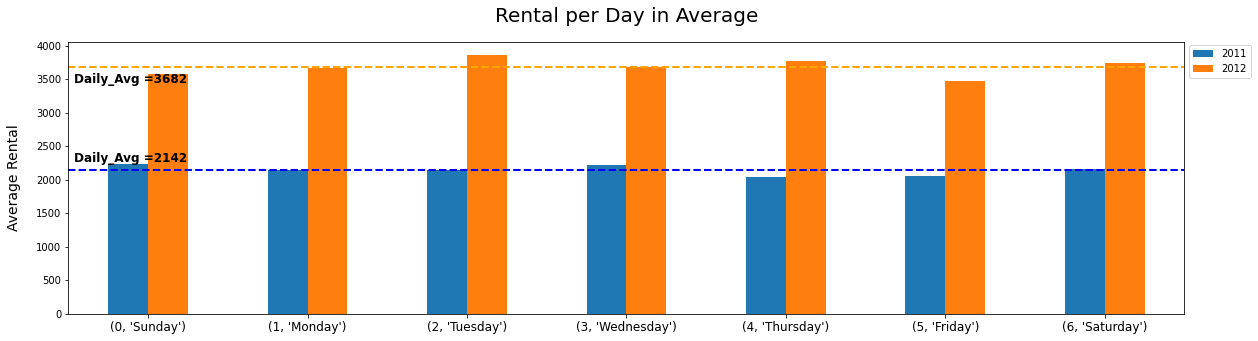

In [23]:
df_dayAggr = df.resample('D').sum()
df_dayAggr['day']= df_dayAggr.index.dayofweek
df_dayAggr['day_name']= df_dayAggr.index.day_name()
df_dayAggr['year']=df_dayAggr.index.year
df_dayAggr['month']=df_dayAggr.index.month
dayAvg_2011 = df_dayAggr.loc[df_dayAggr['year']==2011,'count'].mean()
dayAvg_2012 = df_dayAggr.loc[df_dayAggr['year']==2012,'count'].mean()

ax = df_dayAggr.sort_values(by='day').groupby(['day_name','year'])['count'].mean().unstack().plot.bar(figsize=(20,5),rot=0);
ax.legend(loc=3, bbox_to_anchor=(1.,0.85));
ax.set_ylabel('Average Rental',size=14,labelpad=15)
ax.set_xlabel('')
sort = [(0,'Sunday'),(1,'Monday'),(2,'Tuesday'),(3,'Wednesday'),(4,'Thursday'),(5,'Friday'),(6,'Staturday')]
sort = dict({0:'Sunday',1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thursday',5:'Friday',6:'Saturday'})
ax.set_xticks(range(len(sort)))
ax.set_xticklabels(sort.items(),size=12);
ax.axhline(y=dayAvg_2011, linewidth=2, color='blue',linestyle='--');
ax.text(0.005,0.56, f'Daily_Avg ={round(dayAvg_2011)}',size=12,weight="bold", transform=ax.transAxes);
ax.axhline(y=dayAvg_2012, linewidth=2, color='orange',linestyle='--');
ax.text(0.005,0.85, f'Daily_Avg ={round(dayAvg_2012)}',size=12,weight="bold", transform=ax.transAxes);
ax.set_title('Rental per Day in Average',size=20,pad=20);



* Rentals per day increase by ~72% in average in 2012 compare 2011
* There isn't significant change during weekdays rentals.
* Tuesday, Thursday, Saturday rentals increase. 
* Thursday increase significantly.
* Sunday rentals decrease.
* Friday show in constant low rentals .

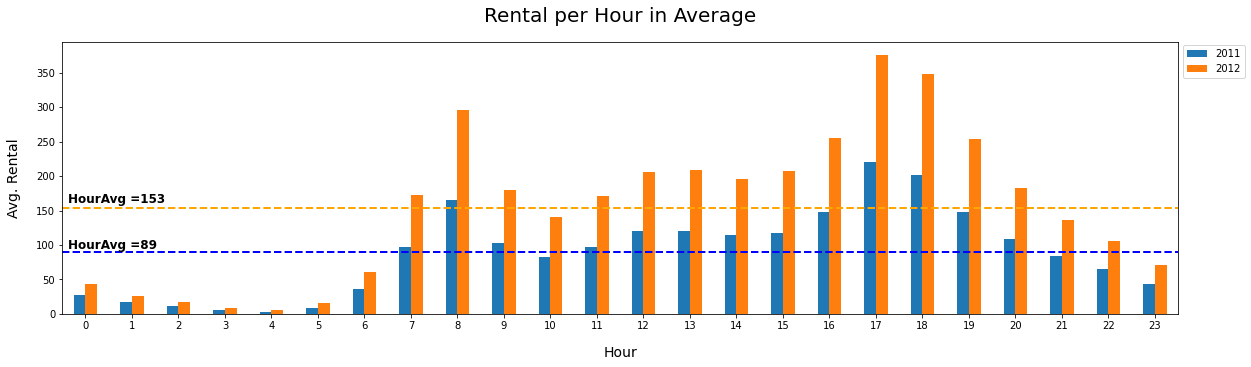

In [24]:
df['Hour']= df.index.hour
HourAvg_2011 = df.loc[df['year']==2011,'count'].mean()
HourAvg_2012 = df.loc[df['year']==2012,'count'].mean()

ax = df.groupby(['Hour','year'])['count'].mean().unstack().plot.bar(figsize=(20,5),rot=0);
ax.legend(loc=3, bbox_to_anchor=(1.,0.85));
ax.set_ylabel('Avg. Rental',size=14,labelpad=15)
ax.set_xlabel('Hour',size=14,labelpad=15)
ax.axhline(y=HourAvg_2011, linewidth=2, color='blue',linestyle='--');
ax.text(0.005,0.24, f'HourAvg ={round(HourAvg_2011)}',size=12,weight="bold", transform=ax.transAxes);
ax.axhline(y=HourAvg_2012, linewidth=2, color='orange',linestyle='--');
ax.text(0.005,0.41, f'HourAvg ={round(HourAvg_2012)}',size=12,weight="bold", transform=ax.transAxes);
ax.set_title('Rental per Hour in Average',size=20,pad=20);

* Most Rentals are between 07:00 - 21:00
* Significant rentals are between 8:00-9:00 , 16:00-20:00. (Bimodal Shape)

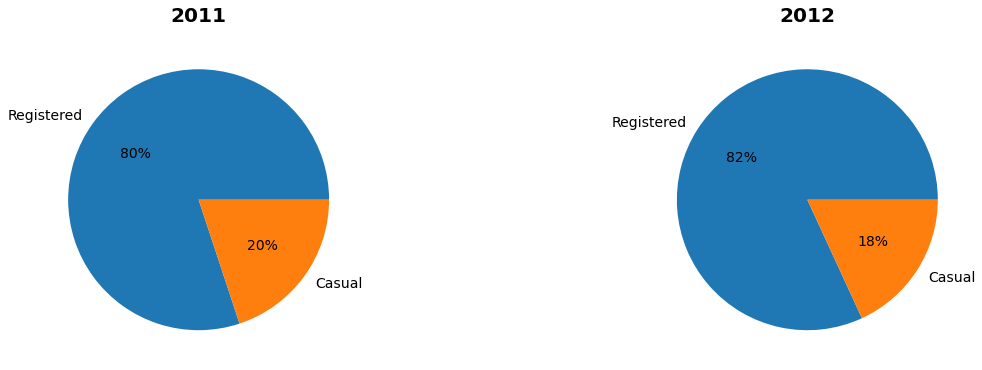

In [25]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(20,6),nrows=1, ncols=2)

ax = df.loc[df['year']==2011,:].groupby(['year']).agg({'registered':'sum','casual':'sum'}).unstack().plot(kind='pie',ax=axes[0],autopct="%.f%%",labels= ['Registered','Casual'] ,textprops={'fontsize': 14});
ax.set_ylabel('');
ax.set_title('2011',size=20,pad=15,fontweight='bold');

bx = df.loc[df['year']==2012,:].groupby(['year']).agg({'registered':'sum','casual':'sum'}).unstack().plot(kind='pie',ax=axes[1],autopct="%.f%%",labels= ['Registered','Casual'] ,textprops={'fontsize': 14});
bx.set_ylabel('');
bx.set_title('2012',size=20,pad=15,fontweight='bold');

There is Increase in usage of Registered Numbers 2012 compare 2011 . Great !

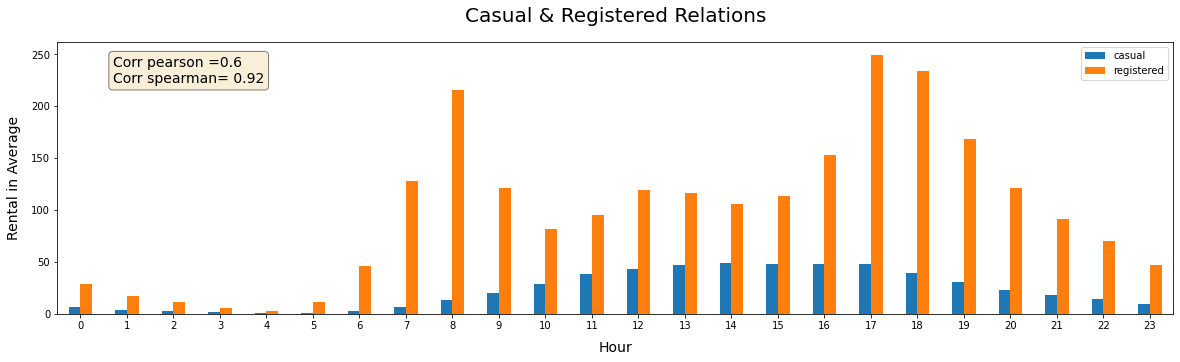

In [26]:
ax = df.groupby('Hour').agg({'casual':'mean','registered':'mean'}).plot(kind='bar',figsize=(20,5),rot=0);
ax.set_ylabel('Rental in Average',size=14,labelpad=10);
ax.set_xlabel('Hour',size=14,labelpad=10);
ax.set_title('Casual & Registered Relations',size=20,pad=20);

pearson_corr = round(df.corr(method='pearson')['casual']['registered'],2)
spearman_corr = round(df.corr(method='spearman')['casual']['registered'],2)
textstr = '\n'.join((f'Corr pearson ={pearson_corr}',f'Corr spearman= {spearman_corr}'))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props);

* We can see different distribution of 'Registered' customers and 'Casual' customers.
* Registered customers use more often in morning : 7:00-10:00 , afternoon : 16:00-19:00 (Bimodal shape)
* Casual customers use more often in noon 13:00-16:00 (Normal distribution like )
* There is correlation between casual and registered customers behavior.
  correlation is non linear.  spearman = 0.92 > pearson = 0.6
* **My estimation : <br>
    Following each distribution  I can assume that predict each group separately and combine them together will show more accuracy results than predict 'count' label.** 

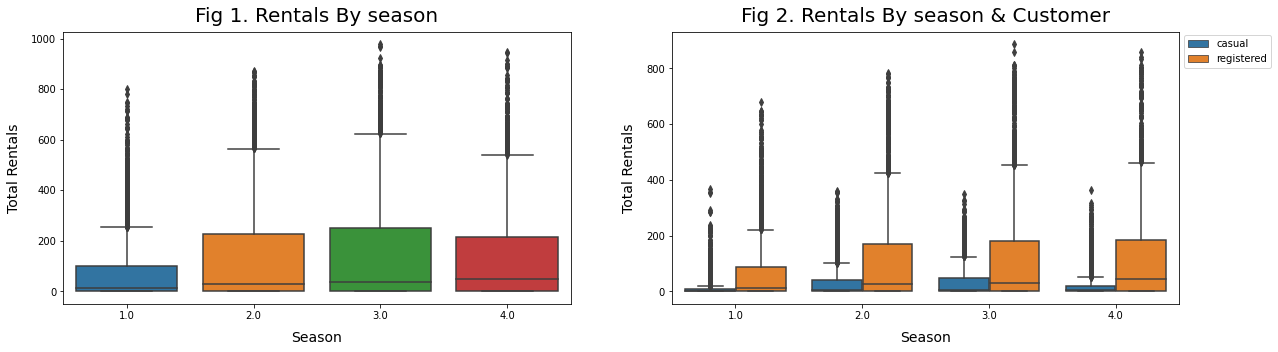

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(figsize=(20,5),nrows=1, ncols=2)
ax= sns.boxplot(x="season", y="count", data=df,ax=axes[0])
ax.set_title('Fig 1. Rentals By season',size=20,pad=10);
ax.set_ylabel('Total Rentals',size=14,labelpad=10);
ax.set_xlabel('Season',size=14,labelpad=10);


chart= pd.melt(df,id_vars='season',value_vars=['casual','registered'],value_name='count',var_name='customer')
bx= sns.boxplot(x="season", y="count", data=chart,hue='customer',ax=axes[1]);
bx.set_title('Fig 2. Rentals By season & Customer',size=20,pad=10);
bx.set_ylabel('Total Rentals',size=14,labelpad=10);
bx.set_xlabel('Season',size=14,labelpad=10);
bx.legend(loc=3, bbox_to_anchor=(1.,0.85));

 
* Fig 1:
  * we can see correlation between season and rentals
* Fig 2:
  * Registered & Casual customers impact by season

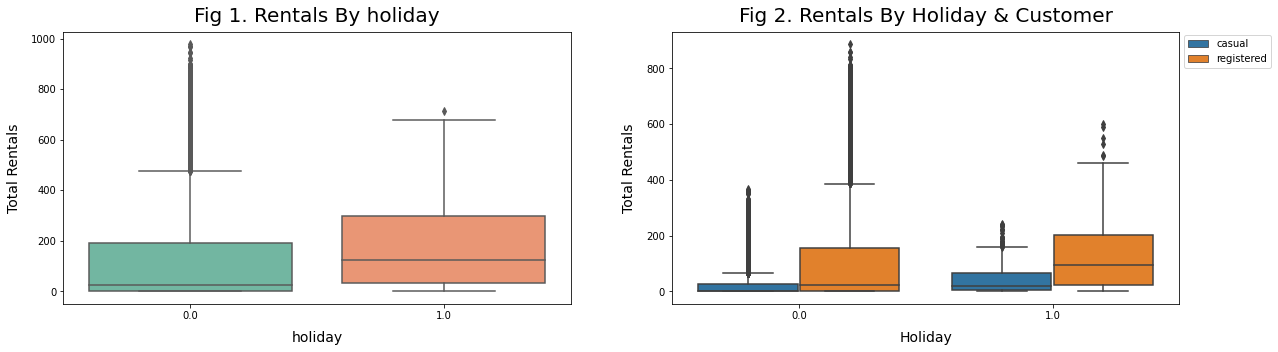

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(figsize=(20,5),nrows=1, ncols=2)
ax= sns.boxplot(x="holiday", y="count", data=df,ax=axes[0],palette ='Set2')
ax.set_title('Fig 1. Rentals By holiday',size=20,pad=10);
ax.set_ylabel('Total Rentals',size=14,labelpad=10);
ax.set_xlabel('holiday',size=14,labelpad=10);


chart= pd.melt(df,id_vars='holiday',value_vars=['casual','registered'],value_name='count',var_name='customer')
bx= sns.boxplot(x="holiday", y="count", data=chart,hue='customer',ax=axes[1] );
bx.set_title('Fig 2. Rentals By Holiday & Customer',size=20,pad=10);
bx.set_ylabel('Total Rentals',size=14,labelpad=10);
bx.set_xlabel('Holiday',size=14,labelpad=10);
bx.legend(loc=3, bbox_to_anchor=(1.,0.85));

* Fig 1:
  * We can see more rentals in holidays. 
* Fig 2:
  * We can see more rentals in holidays for both casual and registered 

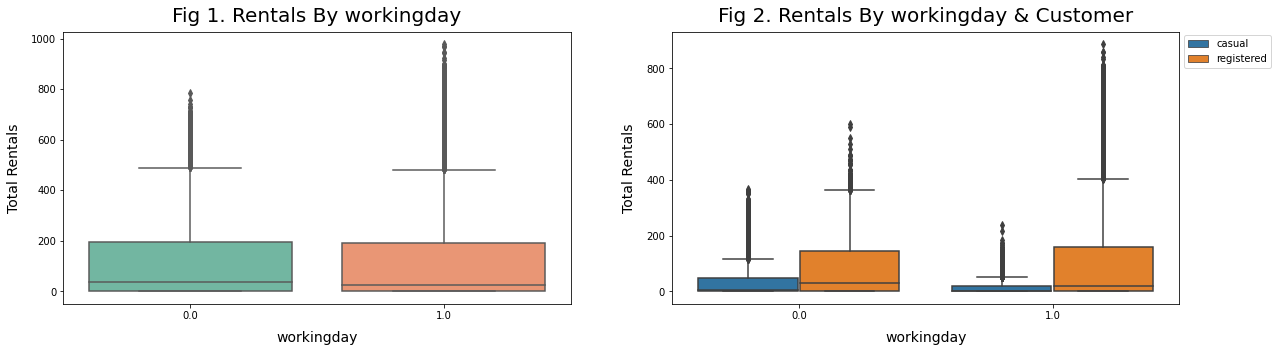

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(figsize=(20,5),nrows=1, ncols=2)
ax= sns.boxplot(x="workingday", y="count", data=df,ax=axes[0],palette ='Set2')
ax.set_title('Fig 1. Rentals By workingday',size=20,pad=10);
ax.set_ylabel('Total Rentals',size=14,labelpad=10);
ax.set_xlabel('workingday',size=14,labelpad=10);


chart= pd.melt(df,id_vars='workingday',value_vars=['casual','registered'],value_name='count',var_name='customer')
bx= sns.boxplot(x="workingday", y="count", data=chart,hue='customer',ax=axes[1] );
bx.set_title('Fig 2. Rentals By workingday & Customer',size=20,pad=10);
bx.set_ylabel('Total Rentals',size=14,labelpad=10);
bx.set_xlabel('workingday',size=14,labelpad=10);
bx.legend(loc=3, bbox_to_anchor=(1.,0.85));

* Fig 1:
  * Rentals are less impacted by workingday. 
* Fig 2:
  * Registered customers activity is not impacted from workingday
  * Casual customers activity are more impacted from workingday: no working >>> more rentals

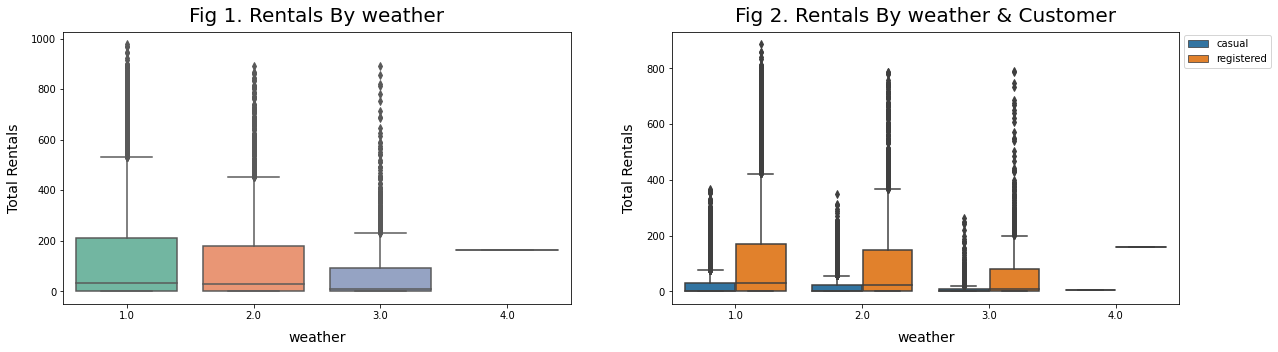

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(figsize=(20,5),nrows=1, ncols=2)
ax= sns.boxplot(x="weather", y="count", data=df,ax=axes[0],palette ='Set2')
ax.set_title('Fig 1. Rentals By weather',size=20,pad=10);
ax.set_ylabel('Total Rentals',size=14,labelpad=10);
ax.set_xlabel('weather',size=14,labelpad=10);


chart= pd.melt(df,id_vars='weather',value_vars=['casual','registered'],value_name='count',var_name='customer')
bx= sns.boxplot(x="weather", y="count", data=chart,hue='customer',ax=axes[1] );
bx.set_title('Fig 2. Rentals By weather & Customer',size=20,pad=10);
bx.set_ylabel('Total Rentals',size=14,labelpad=10);
bx.set_xlabel('weather',size=14,labelpad=10);
bx.legend(loc=3, bbox_to_anchor=(1.,0.85));

* Fig 1:
  * Rentals are impact from weather. 
  * in weather type 4 - only few rentals
* Fig 2:
  * Registered customers activity are impacted from weather
  *  Casual customers activity are impacted from weather

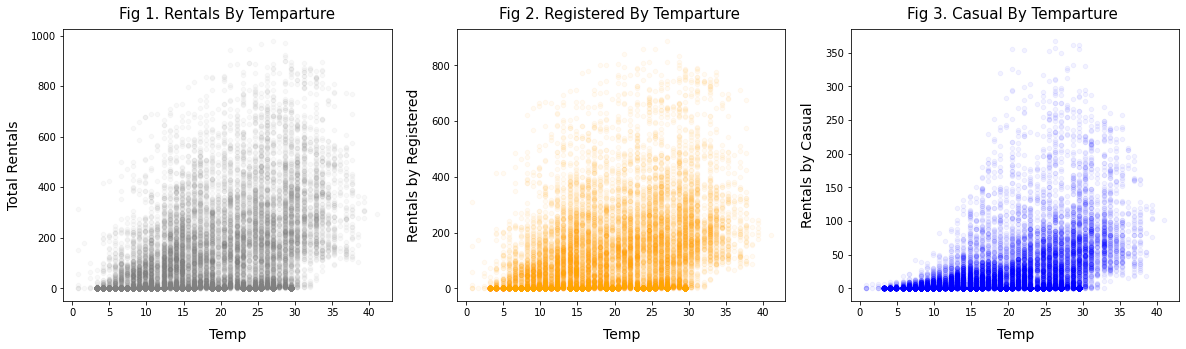

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(figsize=(20,5),nrows=1, ncols=3);

ax= df.plot(kind='scatter',x='temp',y='count',ax=axes[0],alpha=0.05,color='grey');
ax.set_title('Fig 1. Rentals By Temparture',size=15,pad=10);
ax.set_ylabel('Total Rentals',size=14,labelpad=10);
ax.set_xlabel('Temp',size=14,labelpad=10);


bx= df.plot(kind='scatter',x='temp',y='registered',ax=axes[1],alpha=0.05,color='orange');
bx.set_title('Fig 2. Registered By Temparture ',size=15,pad=10);
bx.set_ylabel('Rentals by Registered',size=14,labelpad=10);
bx.set_xlabel('Temp',size=14,labelpad=10);


cx= df.plot(kind='scatter',x='temp',y='casual',ax=axes[2],alpha=0.05,color='blue');
cx.set_title('Fig 3. Casual By Temparture ',size=15,pad=10);
cx.set_ylabel('Rentals by Casual',size=14,labelpad=10);
cx.set_xlabel('Temp',size=14,labelpad=10);
plt.show()

* We can't Identify linear correlation between Temp and Rentals

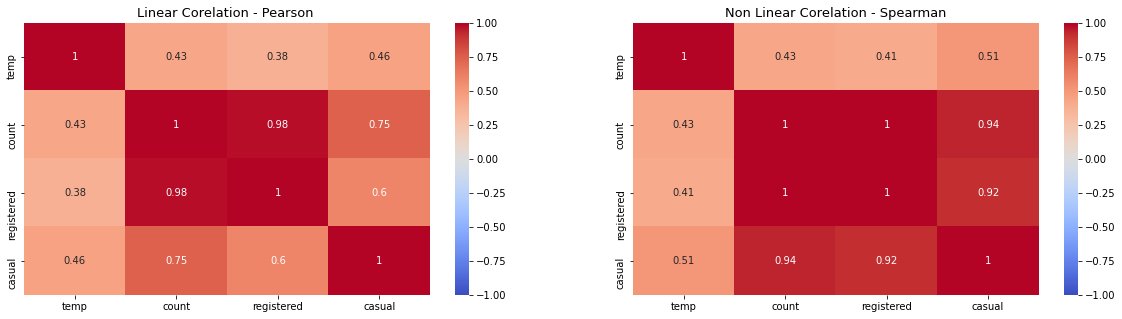

In [32]:
fig, axes = plt.subplots(figsize=(20,5),nrows=1, ncols=2)

# chart 1 pearson
corr = df.loc[:,['temp','count','registered','casual']].corr(method='pearson')
ax = sns.heatmap(corr, annot = True,cmap ='coolwarm',vmin=-1,vmax=1,ax=axes[0]);
ax.set_title('Linear Corelation - Pearson ', y = 1.12, size=13, loc="center");

# chart 1 spearman
corr = df.loc[:,['temp','count','registered','casual']].corr(method='spearman')
ax = sns.heatmap(corr, annot = True,cmap ='coolwarm',vmin=-1,vmax=1,ax=axes[1]);
ax.set_title('Non Linear Corelation - Spearman', y = 1.12, size=13, loc="center");

* There is Medium correlation between Temp and rentals 

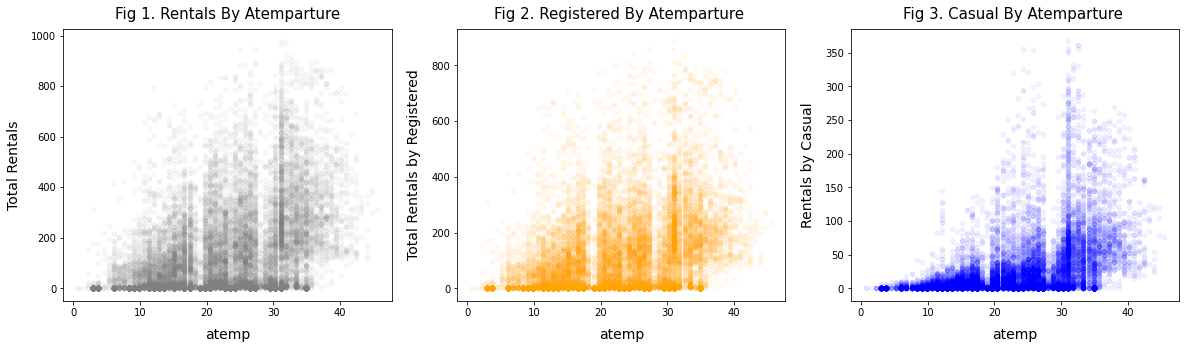

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(figsize=(20,5),nrows=1, ncols=3)

ax= df.plot(kind='scatter',x='atemp',y='count',ax=axes[0],alpha=0.05,color='grey');
ax.set_title('Fig 1. Rentals By Atemparture',size=15,pad=10);
ax.set_ylabel('Total Rentals',size=14,labelpad=10);
ax.set_xlabel('atemp',size=14,labelpad=10);


bx= df.plot(kind='scatter',x='atemp',y='registered',ax=axes[1],alpha=0.05,color='orange');
bx.set_title('Fig 2. Registered By Atemparture ',size=15,pad=10);
bx.set_ylabel('Total Rentals by Registered',size=14,labelpad=10);
bx.set_xlabel('atemp',size=14,labelpad=10);


cx= df.plot(kind='scatter',x='atemp',y='casual',ax=axes[2],alpha=0.05,color='blue');
cx.set_title('Fig 3. Casual By Atemparture ',size=15,pad=10);
cx.set_ylabel('Rentals by Casual',size=14,labelpad=10);
cx.set_xlabel('atemp',size=14,labelpad=10);


* We can't Identify linear correlation between Atemp and Rentals

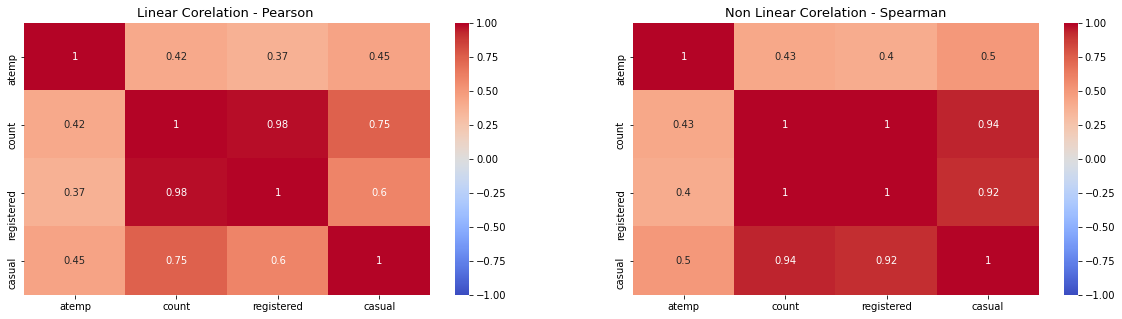

In [34]:
fig, axes = plt.subplots(figsize=(20,5),nrows=1, ncols=2)

# chart 1 pearson
corr = df.loc[:,['atemp','count','registered','casual']].corr(method='pearson')
ax = sns.heatmap(corr, annot = True,cmap ='coolwarm',vmin=-1,vmax=1,ax=axes[0]);
ax.set_title('Linear Corelation - Pearson ', y = 1.12, size=13, loc="center");

# chart 1 spearman
corr = df.loc[:,['atemp','count','registered','casual']].corr(method='spearman')
ax = sns.heatmap(corr, annot = True,cmap ='coolwarm',vmin=-1,vmax=1,ax=axes[1]);
ax.set_title('Non Linear Corelation - Spearman', y = 1.12, size=13, loc="center");

* There is Very Medium correlation between Atemp to Rentals.

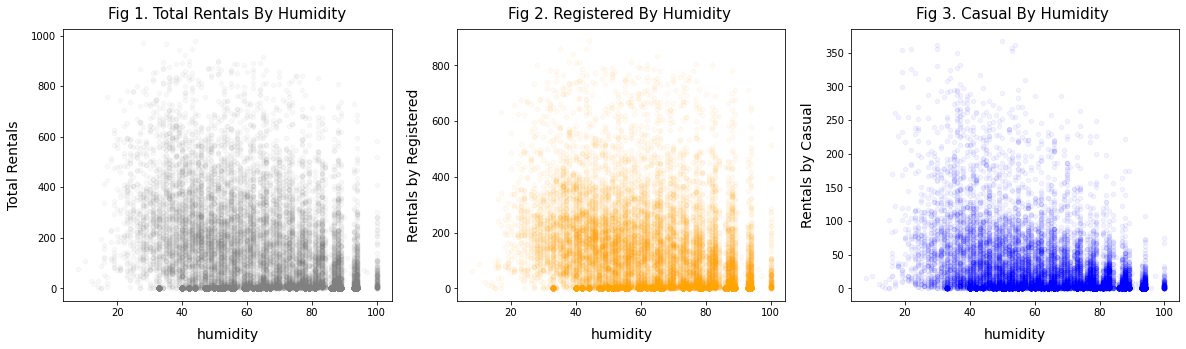

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(figsize=(20,5),nrows=1, ncols=3)

ax= df.plot(kind='scatter',x='humidity',y='count',ax=axes[0],alpha=0.05,color='grey');
ax.set_title('Fig 1. Total Rentals By Humidity',size=15,pad=10);
ax.set_ylabel('Total Rentals',size=14,labelpad=10);
ax.set_xlabel('humidity',size=14,labelpad=10);


bx= df.plot(kind='scatter',x='humidity',y='registered',ax=axes[1],alpha=0.05,color='orange');
bx.set_title('Fig 2. Registered By Humidity ',size=15,pad=10);
bx.set_ylabel('Rentals by Registered',size=14,labelpad=10);
bx.set_xlabel('humidity',size=14,labelpad=10);


cx= df.plot(kind='scatter',x='humidity',y='casual',ax=axes[2],alpha=0.05,color='blue');
cx.set_title('Fig 3. Casual By Humidity ',size=15,pad=10);
cx.set_ylabel('Rentals by Casual',size=14,labelpad=10);
cx.set_xlabel('humidity',size=14,labelpad=10);


* We can't Identify linear correlation between Humidity and Rentals

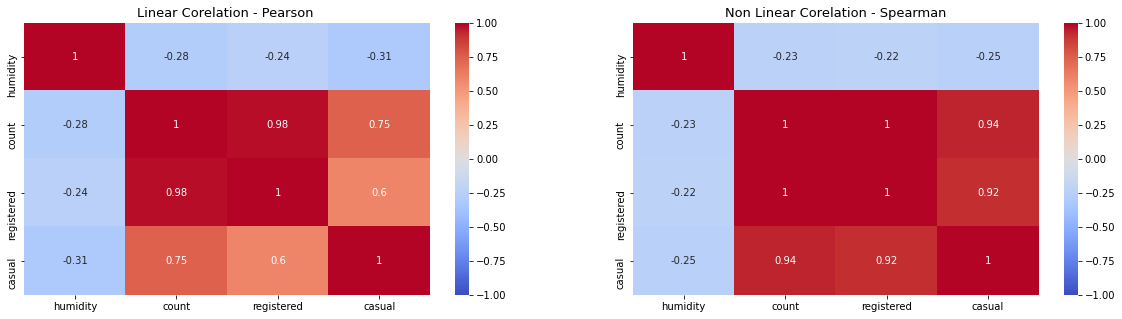

In [36]:
fig, axes = plt.subplots(figsize=(20,5),nrows=1, ncols=2)

# chart 1 pearson
corr = df.loc[:,['humidity','count','registered','casual']].corr(method='pearson')
ax = sns.heatmap(corr, annot = True,cmap ='coolwarm',vmin=-1,vmax=1,ax=axes[0]);
ax.set_title('Linear Corelation - Pearson ', y = 1.12, size=13, loc="center");

# chart 1 spearman
corr = df.loc[:,['humidity','count','registered','casual']].corr(method='spearman')
ax = sns.heatmap(corr, annot = True,cmap ='coolwarm',vmin=-1,vmax=1,ax=axes[1]);
ax.set_title('Non Linear Corelation - Spearman', y = 1.12, size=13, loc="center");


* There is Weak negative correlation between humidity and rentals. <br>
Humidity  go down rentals go up

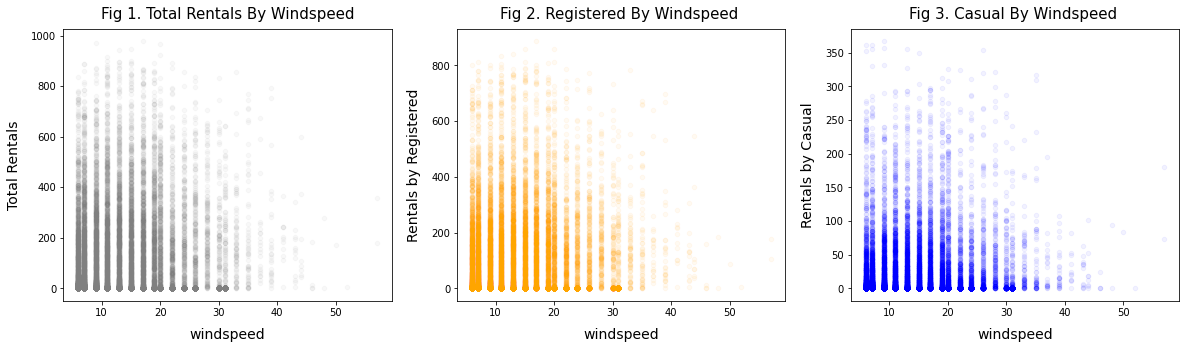

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(figsize=(20,5),nrows=1, ncols=3)

ax= df.plot(kind='scatter',x='windspeed',y='count',ax=axes[0],alpha=0.05,color='grey');
ax.set_title('Fig 1. Total Rentals By Windspeed',size=15,pad=10);
ax.set_ylabel('Total Rentals',size=14,labelpad=10);
ax.set_xlabel('windspeed',size=14,labelpad=10);


bx= df.plot(kind='scatter',x='windspeed',y='registered',ax=axes[1],alpha=0.05,color='orange');
bx.set_title('Fig 2. Registered By Windspeed ',size=15,pad=10);
bx.set_ylabel('Rentals by Registered',size=14,labelpad=10);
bx.set_xlabel('windspeed',size=14,labelpad=10);


cx= df.plot(kind='scatter',x='windspeed',y='casual',ax=axes[2],alpha=0.05,color='blue');
cx.set_title('Fig 3. Casual By Windspeed ',size=15,pad=10);
cx.set_ylabel('Rentals by Casual',size=14,labelpad=10);
cx.set_xlabel('windspeed',size=14,labelpad=10);


We can't see any linear correlation between windspeed and Rentals

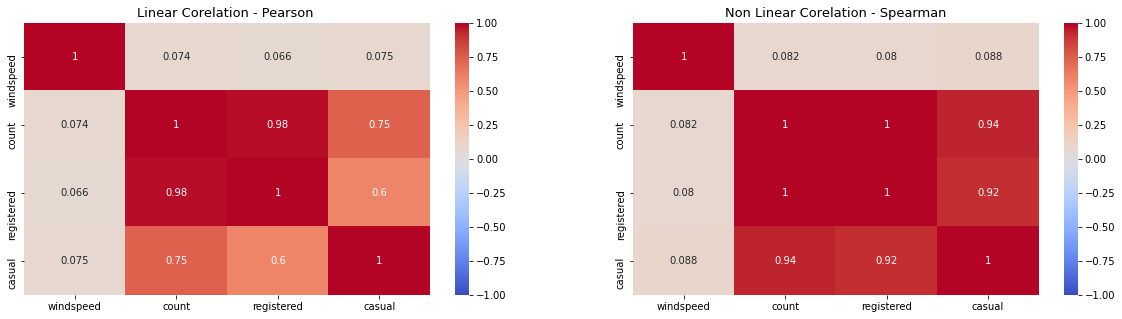

In [38]:
fig, axes = plt.subplots(figsize=(20,5),nrows=1, ncols=2)

# chart 1 pearson
corr = df.loc[:,['windspeed','count','registered','casual']].corr(method='pearson')
ax = sns.heatmap(corr, annot = True,cmap ='coolwarm',vmin=-1,vmax=1,ax=axes[0]);
ax.set_title('Linear Corelation - Pearson ', y = 1.12, size=13, loc="center");

# chart 1 spearman
corr = df.loc[:,['windspeed','count','registered','casual']].corr(method='spearman')
ax = sns.heatmap(corr, annot = True,cmap ='coolwarm',vmin=-1,vmax=1,ax=axes[1]);
ax.set_title('Non Linear Corelation - Spearman', y = 1.12, size=13, loc="center");


* There isn't correlation between windspeed and rentals - weird !

**Correlation Summary:**

  * There is correlation between :
     * Rentals - season
     * Rentals - holidays 
     * Rental - workingday (weak correlation)
     * Rental - weather type
     * Rental - Temp 
     * Rental - Atemp 
     * Rental - Humidity (negative correlation)
     * Rental - windspeed (no correlation) - weird !


## **MultiColinear Test**

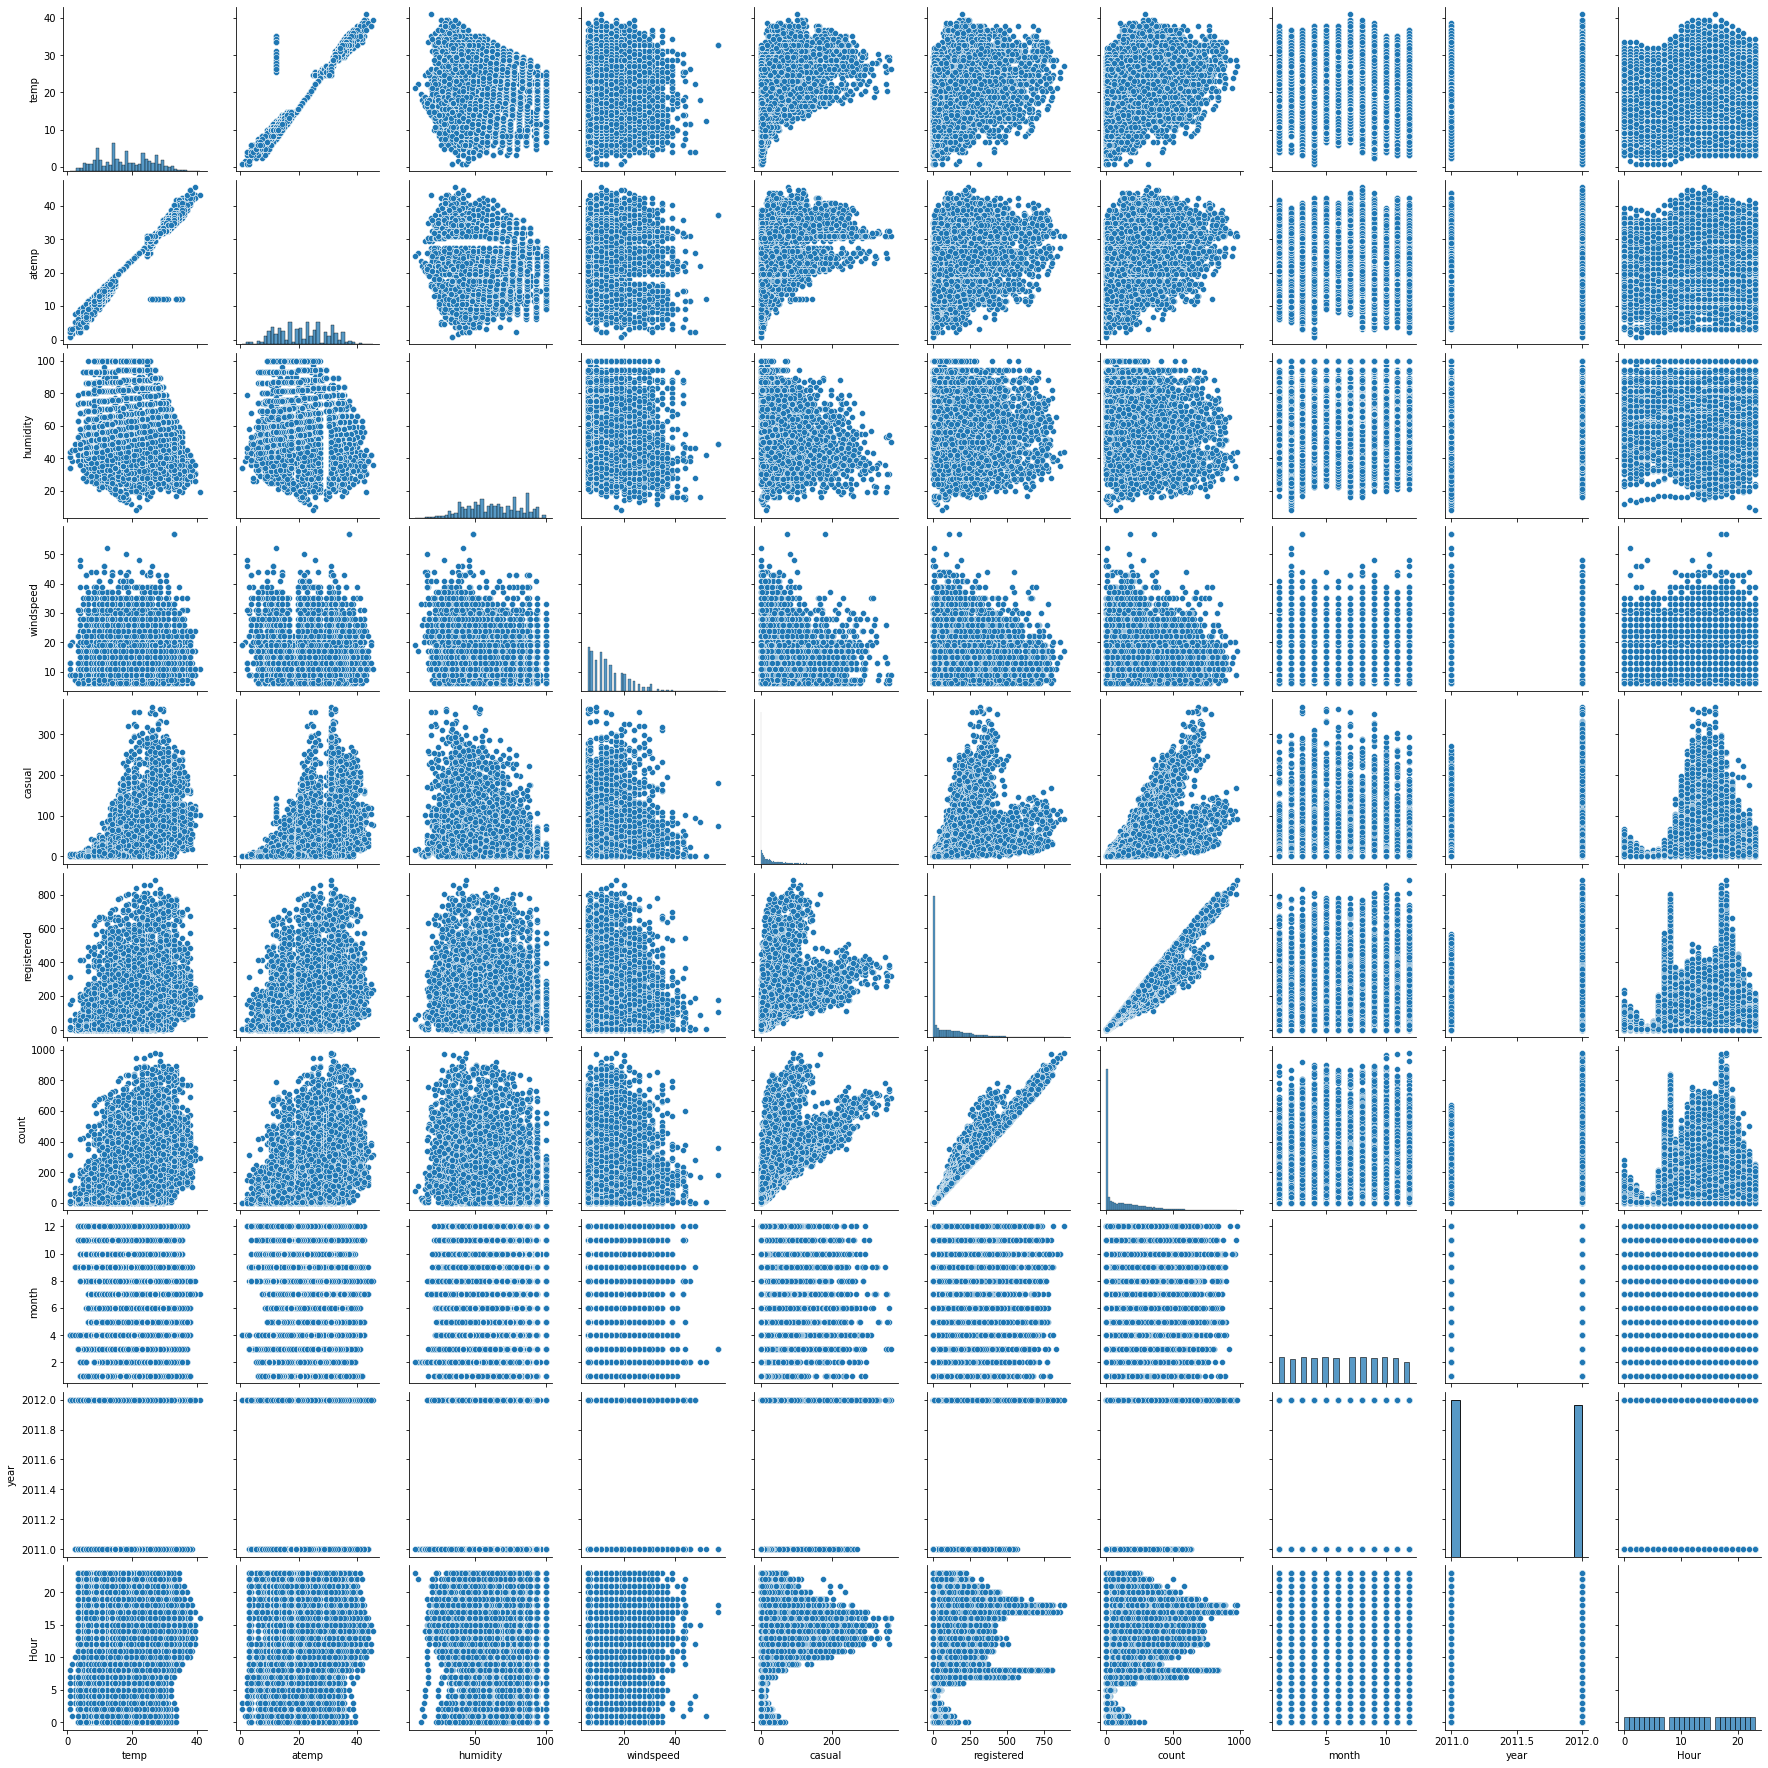

In [39]:
sns.pairplot(df);

**Multi colinear Summary:**

  * There is very strong correlation between Temp - Atemp
  * Atemp should drop. Temp show stronger relation to Rentals

**Drop 'Atemp'**

In [40]:
del df['atemp']

**Drop unrelevant data**

In [41]:
df.drop(columns= ['month','month_name','year','Hour','casual','registered'],inplace=True)

casual and registered are part from target and not attributes

## **Statistic Summary**

In [42]:
df.describe()

,temp,humidity,windspeed,count
count,17256.000000,17256.000000,17256.000000,17256.000000
mean,18.234070,63.465577,13.770278,120.855123
std,8.050872,18.683246,7.114871,171.017327
min,0.820000,8.000000,6.003200,0.000000
25%,11.480000,49.000000,7.001500,0.000000
50%,18.040000,63.000000,12.998000,29.000000
75%,24.600000,79.000000,19.001200,194.000000
max,41.000000,100.000000,56.996900,977.000000


**No outliers to treat**

## **Categorical Frequency**

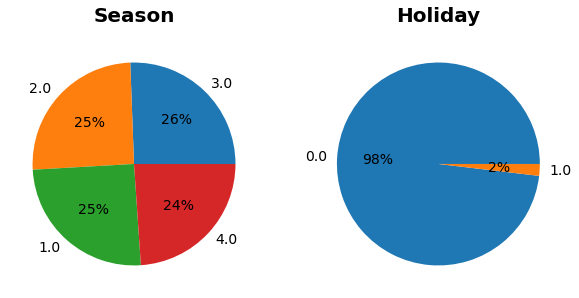

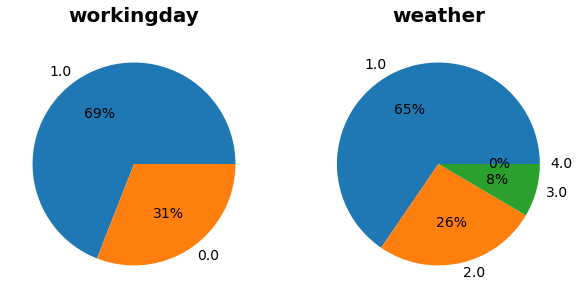

In [43]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(10,6),nrows=1, ncols=2)

ax = df['season'].value_counts().plot(kind='pie',ax=axes[0],autopct="%.f%%",textprops={'fontsize': 14});
ax.set_ylabel('');
ax.set_title('Season',size=20,pad=15,fontweight='bold');

bx = df['holiday'].value_counts().plot(kind='pie',ax=axes[1],autopct="%.f%%",textprops={'fontsize': 14});
bx.set_ylabel('');
bx.set_title('Holiday',size=20,pad=15,fontweight='bold');

fig, axes = plt.subplots(figsize=(10,6),nrows=1, ncols=2)
ax = df['workingday'].value_counts().plot(kind='pie',ax=axes[0],autopct="%.f%%",textprops={'fontsize': 14});
ax.set_ylabel('');
ax.set_title('workingday',size=20,pad=15,fontweight='bold');

bx = df['weather'].value_counts().plot(kind='pie',ax=axes[1],autopct="%.f%%",textprops={'fontsize': 14});
bx.set_ylabel('');
bx.set_title('weather',size=20,pad=15,fontweight='bold');


In 'Weather' we can see category 4 is less than 1% . <br>
Can cause problem when Train- Test split. <br>


## **Categorical correlation (Chi Square)**

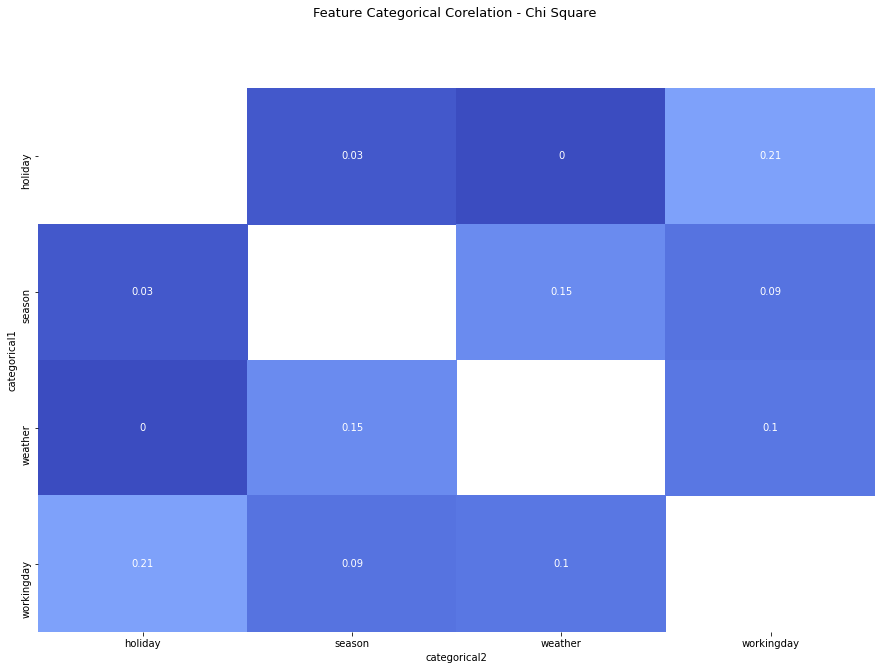

In [44]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns


categorical_data = df.loc[:,df.columns.isin(df.select_dtypes('object').columns.to_list())]


# calculate correlation
feature1 = []
feature2 = []
cramer = [] 

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

x=0
while True:
     y=0
     while y < len(categorical_data.columns) :
          feature1.append(categorical_data.iloc[:,x].name)
          feature2.append(categorical_data.iloc[:,y].name) 
          result = cramers_v(categorical_data.iloc[:,x], categorical_data.iloc[:,y])         
          cramer.append(result)    
          y+=1
     x+=1
     if x == len(categorical_data.columns) :
        break
  

# create correlation table
cramer_table = pd.DataFrame(zip(feature1,feature2,cramer)).rename(columns={0:'categorical1',1:'categorical2',2:'Cramer correlation'})


#show heat map (above 0.75 strong relation)
cramer_table = cramer_table.loc[(cramer_table['Cramer correlation'] >=0.0) & (cramer_table.categorical1 != cramer_table.categorical2),:]
plt.figure(figsize=(15,10))
plt.title('Feature Categorical Corelation - Chi Square ', y = 1.12, size=13, loc="center")
sns.heatmap(pd.crosstab(cramer_table.categorical1,
            cramer_table.categorical2,
            values=round(cramer_table['Cramer correlation'],2),
            aggfunc= 'sum'),
            cmap="coolwarm", annot=True, cbar=False,vmin = 0, vmax = 1,center = 0.5)
plt.show()

No correlation between categorical features

## **Feature Importance**

In [45]:
X = df.drop(columns='count')
y = df['count']

In [46]:
def to_integer (feature):
   return feature.astype('float').astype('int')
   
for feature in ['season','holiday','workingday','weather']:
    df[feature] = to_integer(df[feature])

**1.Boruta random forest**

In [47]:
import numpy as np
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

###initialize Boruta
forest = RandomForestRegressor(n_jobs = -1, max_depth = 5)
boruta = BorutaPy(estimator = forest, n_estimators = 'auto', max_iter = 100) # number of trials to perform


### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(np.array(X),np.array(y))

# score
green_area = X.columns[boruta.support_].to_list()
blue_area = X.columns[boruta.support_weak_].to_list()
Boruta_RF = pd.Series(green_area + blue_area).to_frame('Boruta_RF')

**2.Light GBM (boosting method)**

Learn from weak Attributes

In [48]:
import lightgbm as lgb
model = lgb.LGBMRegressor(boosting_type='dart',objective='RMSE',random_state=1,reg_alpha=1,learning_rate= 0.0000001,subsample= 0.5)
model.fit(X.values,y)
LGB = pd.DataFrame(zip(X.columns.to_list(),model.feature_importances_.tolist()),columns=['feature','importance'])
LGB = LGB.loc[LGB.importance > 0,'feature'].to_frame('LGB').reset_index(drop=True)

3. **Summary : Voting for importance attributes**

In [49]:
Attributes = pd.Series(X.columns).to_frame('Attributes')
summary = pd.merge(
                    left =pd.merge(Attributes,Boruta_RF,how='left',left_on='Attributes',right_on='Boruta_RF')
                    ,right =  LGB, left_on='Attributes',right_on='LGB',how='left')

for column in summary.drop(columns = 'Attributes').columns:
    summary[column] = summary[column].apply(lambda x: 0 if pd.isnull(x)==True else 1)

summary['score'] = summary.sum(axis=1)
summary = summary.sort_values(by='score',ascending=False).reset_index(drop=True) 
display(summary)

,Attributes,Boruta_RF,LGB,score
0,season,1,1,2
1,workingday,1,1,2
2,weather,1,1,2
3,temp,1,1,2
4,humidity,1,1,2
5,windspeed,1,1,2
6,holiday,0,0,0


## **Feature selection**

* Holiday isn't important and should drop - weird ! <br> (previously we saw there is correlation)
* Other features as important according table summary of feature importance

In [50]:
df = df.drop(columns='holiday')

In [51]:
print("""
           Important features:\n
            ['season', 'workingday', 'weather', 'temp', 'humidity', 'windspeed']
      """)


           Important features:

            ['season', 'workingday', 'weather', 'temp', 'humidity', 'windspeed']
      


## **Train, Test split**

* Train - all data except last 3 month (hourly)
* Test - Last 3 month (hourly)

In [52]:
train = df[:'2012-09-18'].reset_index()
test = df['2012-09-19':'2012-12-19'].reset_index()

## **Encoding Categorical - One Hot Encoding**

In [53]:
to_obj = ['season','workingday','weather']

def to_object(x):
    return x.astype(str)

for column in to_obj :
    train[column] = to_object(train[column])
    test[column] = to_object(test[column])

In [54]:
X_categorical = ['season','workingday','weather']
X_numerical = ['temp','humidity','windspeed']
y_target= 'count'

# Fit transform One Hot Encoding train
DummyTable = {}
features = {}
categorical_features = pd.DataFrame()
for column in X_categorical:
    DummyTable[column] = pd.concat( [train[column].drop_duplicates().to_frame().reset_index(drop=True)
                          ,pd.get_dummies(data=train[column].to_frame(),columns=[column],drop_first=False).drop_duplicates().reset_index(drop=True)]  
                          ,axis= 1)
    features[column] = pd.merge(train[column].to_frame(),DummyTable[column],how='left',on=column)
    categorical_features = pd.concat([categorical_features,features[column]],axis=1)
    categorical_features.drop(columns= [column,column+'_1'],inplace=True)

train = pd.concat([train['datetime'],categorical_features,train.loc[:,train.columns.isin(X_numerical)],train[y_target]],axis=1).set_index('datetime')

# Predict One Hot Encoding test
categorical_features = pd.DataFrame()
for column in X_categorical:
    features[column] = pd.merge(test[column].to_frame(),DummyTable[column],how='left',on=column)
    categorical_features = pd.concat([categorical_features,features[column]],axis=1)
    categorical_features.drop(columns= [column,column+'_1'],inplace=True)

test = pd.concat([test['datetime'],categorical_features,test.loc[:,test.columns.isin(X_numerical)],test[y_target]],axis=1).set_index('datetime')


In [55]:
# add index frequency 
train.index.freq='h'
test.index.freq='h'

In [56]:
print('train')
display(train.shape)
display(train.head(2))
print("")
print('test')
display(test.shape)
display(test.head(2))


train


(15048, 11)

,season_2,season_3,season_4,workingday_0,weather_2,weather_3,weather_4,temp,humidity,windspeed,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,0,0,0,1,0,0,0,9.84,81.0,6.0032,16
2011-01-01 01:00:00,0,0,0,1,0,0,0,9.02,80.0,6.0032,40



test


(2208, 11)

,season_2,season_3,season_4,workingday_0,weather_2,weather_3,weather_4,temp,humidity,windspeed,count
datetime,,,,,,,,,,,
2012-09-19 00:00:00,0,1,0,0,1,0,0,22.96,68.0,19.0012,26
2012-09-19 01:00:00,0,1,0,0,1,0,0,22.14,68.0,16.9979,12


## **Choosing Model Type & Hyperparameter Tuning**

Predict methods - focus on Target and time interval

**Simple Moving Average**

In [57]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing


span = 24
alpha = 2/(span+1)

model =SimpleExpSmoothing(train['count']).fit(smoothing_level=alpha,optimized=False)
SimpleExp = model.forecast(2208).rename('prediction')

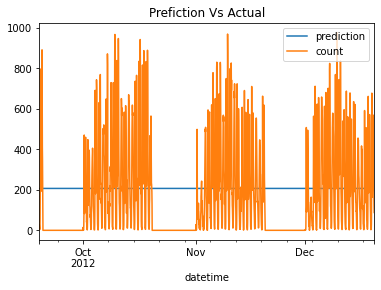

In [58]:
ax= SimpleExp.plot(legend=True);
ax.set_title('Prefiction Vs Actual')
test['count'].plot(legend=True);

SimpleExp didn't learn anything

**Double Exponential smoothing**

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


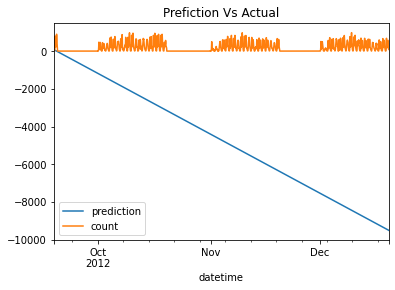

In [59]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

span = 24
alpha = 2/(span+1)
model = ExponentialSmoothing(train['count'], trend='add').fit()
ExponentialSmooth = model.forecast(2208).rename('prediction')

bx= ExponentialSmooth.plot(legend=True);
bx.set_title('Prefiction Vs Actual')
test['count'].plot(legend=True);

**ExponentialSmooth didn't learn anything**

**Triple Exponential**

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


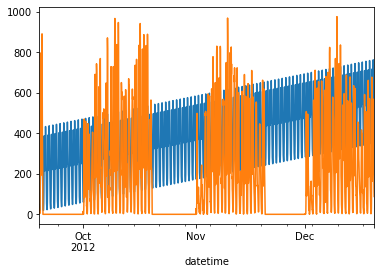

In [60]:
model = ExponentialSmoothing(train['count'], trend='add',seasonal='add',seasonal_periods=24).fit()
tripleExp = model.forecast(2208).rename('prediction')

tripleExp.plot();
test['count'].plot();

Triple exponent didn't learn anything

In [61]:
from statsmodels.tools.eval_measures import mse,rmse

error1 = mse(test['count'], tripleExp)
error2 = rmse(test['count'], tripleExp)
print(f'MSE ={error1}, RMSE={error2}')
print(f'Mean ={test["count"].mean()}, Std={test["count"].std()}')

MSE =77036.63364197026, RMSE=277.55473990182594
Mean =151.8201992753623, Std=204.03073946276783


**AR - autoregressive model**

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


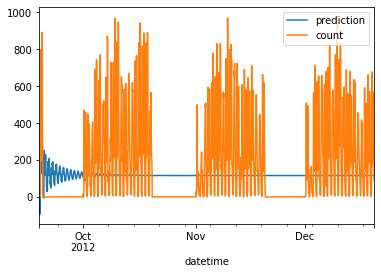

In [62]:
from statsmodels.tsa.ar_model import AR,ARResults

model = AR(train['count'])
ARfit = model.fit(method='mle')
start = len(train)
end = len(train)+len(test)-1
predictions = ARfit.predict(start=start,end=end,dynamic=False).rename('prediction')

predictions.plot(legend=True);
test['count'].plot(legend=True);

Model Didn't learn Anything

Stationary Test

stationary meaning - no trend and no seasonality

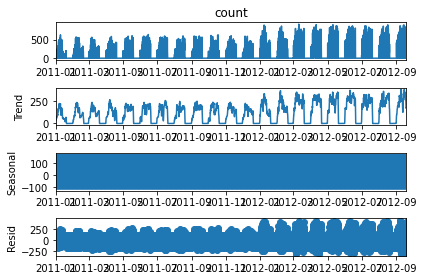

In [63]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(train['count'], model='add')  # model='mul' also works
result.plot();

* We can see **in hourly time frame** :
  * No clear trend 
  * No clear seasonality


In [64]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

adf_test(train['count'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -6.295789e+00
p-value                 3.508719e-08
# lags used             4.300000e+01
# observations          1.500400e+04
critical value (1%)    -3.430786e+00
critical value (5%)    -2.861733e+00
critical value (10%)   -2.566873e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


**ARMA Model**

Using For Trend and seasonaliy - not in our case, we run it for check)

In [65]:
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.arima_model import ARMA,ARMAResults
from pmdarima import auto_arima

In [69]:
auto_arima(y= train['count']).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                15048
Model:               SARIMAX(5, 1, 3)   Log Likelihood              -84383.754
Date:                Wed, 03 Feb 2021   AIC                         168785.507
Time:                        09:21:47   BIC                         168854.078
Sample:                             0   HQIC                        168808.254
                              - 15048                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2737      0.007     38.383      0.000       0.260       0.288
ar.L2         -0.3345      0.007    -50.910      0.000      -0.347      -0.322
ar.L3          0.7899      0.006    123.878      0.000       0.777       0.802
ar.L4         -0.4580      0.006    -76.956      0.000      -0.470      -0.446
ar.L5          0.1545      0.008     20.001      0.000       0.139       0.170
ma.L1          0.0348      0.004      8.885      0.000       0.027       0.042
ma.L2         -0.0182      0.004     -4.755      0.000      -0.026      -0.011
ma.L3         -0.9483      0.004   -245.836      0.000      -0.956      -0.941
sigma2      4464.7692     30.516    146.309      0.000    4404.959    4524.580
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             38894.24
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.53   Skew:                             0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [70]:
auto_arima(train['count'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                15048
Model:               SARIMAX(5, 1, 3)   Log Likelihood              -84383.754
Date:                Wed, 03 Feb 2021   AIC                         168785.507
Time:                        09:30:20   BIC                         168854.078
Sample:                             0   HQIC                        168808.254
                              - 15048                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2737      0.007     38.383      0.000       0.260       0.288
ar.L2         -0.3345      0.007    -50.910      0.000      -0.347      -0.322
ar.L3          0.7899      0.006    123.878      0.000       0.777       0.802
ar.L4         -0.4580      0.006    -76.956      0.000      -0.470      -0.446
ar.L5          0.1545      0.008     20.001      0.000       0.139       0.170
ma.L1          0.0348      0.004      8.885      0.000       0.027       0.042
ma.L2         -0.0182      0.004     -4.755      0.000      -0.026      -0.011
ma.L3         -0.9483      0.004   -245.836      0.000      -0.956      -0.941
sigma2      4464.7692     30.516    146.309      0.000    4404.959    4524.580
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             38894.24
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.53   Skew:                             0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**SARIMAX model** - (Contain Exogen Features  -  season, workingday,	weather,humidity	windspeed	)

ARIMA, or Autoregressive Integrated Moving Average is actually a combination of 3 models:

* AR(p) Autoregression - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period
* I(d) Integration - uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary
* MA(q) Moving Average - a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

---



In [73]:
from pmdarima import auto_arima
X_train = train.drop(columns='count')
y_train = train['count']
auto_arima(y= y_train,X=X_train,seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                15048
Model:               SARIMAX(5, 1, 1)   Log Likelihood              -84304.086
Date:                Wed, 03 Feb 2021   AIC                         168642.172
Time:                        10:02:17   BIC                         168771.694
Sample:                    01-01-2011   HQIC                        168685.139
                         - 09-18-2012                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
season_2       -15.3018      8.795     -1.740      0.082     -32.539       1.935
season_3       -39.3404     10.401     -3.782      0.000     -59.725     -18.955
season_4         1.4728      9.701      0.152      0.879     -17.542      20.487
workingday_0    23.3323      4.364      5.346      0.000      14.778      31.886
weather_2        0.0514      1.392      0.037      0.971      -2.676       2.779
weather_3       -5.6375      2.259     -2.495      0.013     -10.066      -1.209
weather_4      -14.0771     52.174     -0.270      0.787    -116.336      88.181
temp             5.4396      0.383     14.207      0.000       4.689       6.190
humidity        -0.9134      0.078    -11.776      0.000      -1.065      -0.761
windspeed        0.2241      0.099      2.262      0.024       0.030       0.418
ar.L1            1.2006      0.006    186.044      0.000       1.188       1.213
ar.L2           -0.6030      0.011    -55.054      0.000      -0.625      -0.582
ar.L3            0.1638      0.015     10.977      0.000       0.135       0.193
ar.L4            0.0813      0.015      5.435      0.000       0.052       0.111
ar.L5           -0.1386      0.009    -14.602      0.000      -0.157      -0.120
ma.L1           -0.9679      0.003   -313.133      0.000      -0.974      -0.962
sigma2        4303.5350     23.809    180.751      0.000    4256.870    4350.200
===================================================================================
Ljung-Box (L1) (Q):                   4.31   Jarque-Bera (JB):             64245.66
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               2.51   Skew:                             0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## **Modeling**

In [74]:
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(endog=y_train,exog=X_train,order=(5, 1, 1),enforce_invertibility=False)
results = model.fit()

In [75]:
# Obtain predicted values
X_test = test.drop(columns='count')
y_test = test['count']
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end,exog=X_test, dynamic=False).rename('SARIMAX(5, 1, 1) Predictions')

In [76]:
predictions.head()

2012-09-19 00:00:00     94.770183
2012-09-19 01:00:00    124.043136
2012-09-19 02:00:00    164.044308
2012-09-19 03:00:00    183.307625
2012-09-19 04:00:00    203.588227
Freq: H, Name: SARIMAX(5, 1, 1) Predictions, dtype: float64

In [77]:
y_test.head()

datetime
2012-09-19 00:00:00    26
2012-09-19 01:00:00    12
2012-09-19 02:00:00     3
2012-09-19 03:00:00     5
2012-09-19 04:00:00    10
Freq: H, Name: count, dtype: int64

## **Evaluate Results**

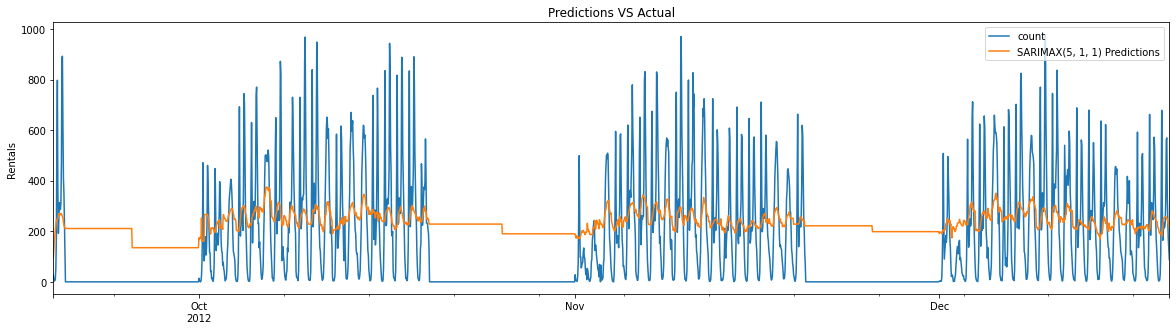

In [78]:
# Plot predictions against known values
title='Total rentals'
ylabel='Rentals'
xlabel=''

ax = test['count'].plot(legend=True,figsize=(20,5));
ax.set_title('Predictions VS Actual')
predictions.plot(legend=True);
ax.autoscale(axis='x',tight=True);
ax.set(xlabel=xlabel, ylabel=ylabel);


In [79]:
from statsmodels.tools.eval_measures import mse,rmse

error1 = mse(test['count'], predictions)
error2 = rmse(test['count'], predictions)
print(f'MSE ={error1}, RMSE={error2}')
print(f'Mean ={test["count"].mean()}, Std={test["count"].std()}')

MSE =38914.49256611529, RMSE=197.26756592535756
Mean =151.8201992753623, Std=204.03073946276783


# **Prediction**

In [80]:
fcast = results.predict(start=len(X_train),end=len(X_train)+len(X_test)-1,exog=X_test).rename('Forecast')

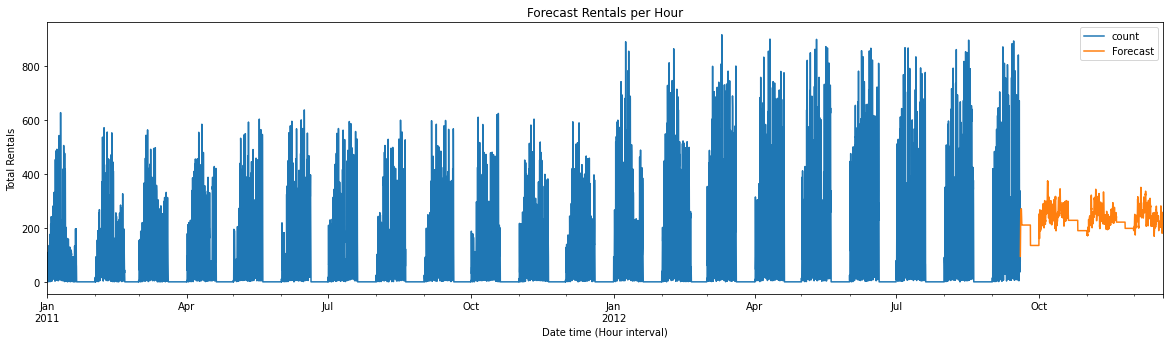

In [81]:
# Plot the forecast alongside historical values
title='Forecast Rentals per Hour'
ylabel='Total Rentals'
xlabel='Date time (Hour interval)'

ax = train['count'].plot(legend=True,figsize=(20,5),title=title);
fcast.plot(legend=True);
ax.autoscale(axis='x',tight=True);
ax.set(xlabel=xlabel, ylabel=ylabel);

# **Summary**


In this case study we tried to predict rentals on hourly base
Our data contain Exogen features that most of them impact and correlate with rentals.
We can see that algoritm contain Exogen features show the best results.
However, the fact our data suffer from sparsity zeros (~40%) impact on prediction and forecast.
My recommendation is to increase time frame to 4 hours interval .
4 hours interval as we show in EDA section have less noise and can be measure more efficiently.